In [19]:
import urllib
import requests
import json
import pandas as pd
from pandas import read_sql
import datetime
import matplotlib.pyplot as plt
import os
import numpy as np
from copy import deepcopy
import pymysql as mdb
import seaborn as sns

In [20]:
afile="/Users/abramvandergeest/mysql_insightwiki_auth.txt"
a=open(afile)
passwd=a.readline().rstrip()
a.close()
host='localhost'; user='abram.ghost';db='wikidata2011'
con = mdb.connect(host, user, passwd, db,port=3307)

In [21]:
#def week_list(base):
#    numdays=7
#    return([base - datetime.timedelta(days=x) for x in range(0, numdays)])

def datefromstr(str):
    return datetime.datetime(int(str[0:4]), int(str[5:7]),int(str[8:]))

str='2015091618'
def date_parse(str):
    year =int(str[:4])
    month=int(str[4:6])
    day=int(str[6:8])
    hour=int(str[8:])
    return datetime.datetime(year,month,day,hour)

def datetime2str(t):
    return "%4d%02d%02d%02d"%(t.year,t.month,t.day,t.hour)
    
def gen_feat(into):
    avg=np.average(into)
    #print avg
    maxv= np.max(into)/avg
    minv= np.min(into)/avg
    rmsv= np.std(into)/avg
    difxv=np.max(np.diff(into))/avg
    difnv=np.min(np.diff(into))/avg
    return([maxv,minv,rmsv,difxv,difnv])
    

In [22]:
call="http://elections.huffingtonpost.com/pollster/api/charts.json"

In [23]:
r = requests.get(call)
r.status_code
r.headers['content-type']
charts=r.json()

In [24]:
terms=['primary','gop','national']
for chart in charts:
    slug=chart['slug']
    if all([t in slug for t in terms]):
        print slug

2012-national-gop-primary
2016-national-gop-primary


In [25]:
call='http://elections.huffingtonpost.com/pollster/api/charts/2012-national-gop-primary'
r = requests.get(call)
r.status_code
r.headers['content-type']
gopprim2012=r.json()

In [26]:
#I need a list of candidates, but not all dates have all candidates 
#so I create a list to add all the candidates for each day then
#I turn it into a set to det the unique values
cand=[]

for date in gopprim2012['estimates_by_date']:
    for est in date['estimates']:
        cand.append(est['choice'])
        #print est
        
cands=set(cand)

In [27]:
rowinit={'date':"2011",'Bachmann':0,'Perry':0,'Huntsman':0,'Santorum':0,'Roemer':0,'Romney':0,'Other':0,'Undecided':0,'Cain':0,'Paul':0,'Not Voting':0,'Karger':0,'Gingrich':0}
data=[]

for date in gopprim2012['estimates_by_date']:
#if True:
    #date=gopprim2012['estimates_by_date'][3]
    row=deepcopy(rowinit)
    #print row
    #print date['date']
    row['date']=datefromstr(date['date'])
    for est in date['estimates']:
         row[est['choice']]=est['value']
    data.append(row)
    #print row
    
df= pd.DataFrame(data)

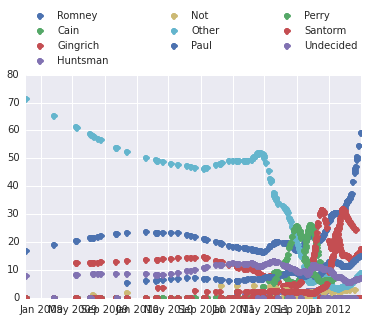

In [28]:
%matplotlib inline
dtp=df[['date','Romney']].values
dtp[0]
plt.plot_date(df[['date']].values,df[['Romney']].values,label="Romney")
plt.plot_date(df[['date']].values,df[['Cain']].values,label="Cain")
plt.plot_date(df[['date']].values,df[['Gingrich']].values,label="Gingrich")
plt.plot_date(df[['date']].values,df[['Huntsman']].values,label="Huntsman")
plt.plot_date(df[['date']].values,df[['Not Voting']].values,label="Not")
plt.plot_date(df[['date']].values,df[['Other']].values,label="Other")
plt.plot_date(df[['date']].values,df[['Paul']].values,label="Paul")
plt.plot_date(df[['date']].values,df[['Perry']].values,label="Perry")
plt.plot_date(df[['date']].values,df[['Santorum']].values,label="Santorm")
plt.plot_date(df[['date']].values,df[['Undecided']].values,label="Undecided")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=3, mode="expand", borderaxespad=0.)
plt.savefig("gophuff.pdf")
#gophuff=plt.show()

dfhuff=df

In [29]:
with con:
    curt= con.cursor()
    #sql="SELECT COUNT(*) FROM `topics` "
    
    sql="SELECT `Id`,`topic_label`,`topic_string` FROM `topics`;"
    curt.execute(sql)
    topics=[]
    for topic in curt:
        topics.append(topic)

data={}

df=range(76)
with con:
    curt= con.cursor()
    #sql="SELECT COUNT(*) FROM `topics` "
    #curt.execute(sql)
    sql="SELECT `Id`,`topic_label`,`topic_string` FROM `topics`;"
    curt.execute(sql)
    for row in curt:
        #cur = con.cursor()
        sql='''SELECT `page_views`.`count` AS `vc`,`page_views`.`date` AS `vd` 
             FROM `topics` INNER JOIN `page_views` on `topics`.`ID` = `page_views`.`topic_id` 
             WHERE `topics`.`id`=%s '''

        #print sql
        
        data[row[1]]=read_sql(sql, con,params=[row[0]])
        df[row[0]]=data[row[1]]
        #data[row[1]]=df[len(df)-1][1]

topicdata=df

hermancain


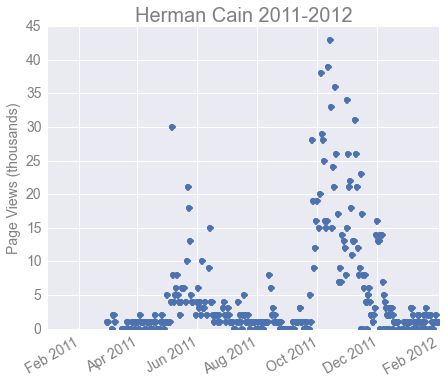

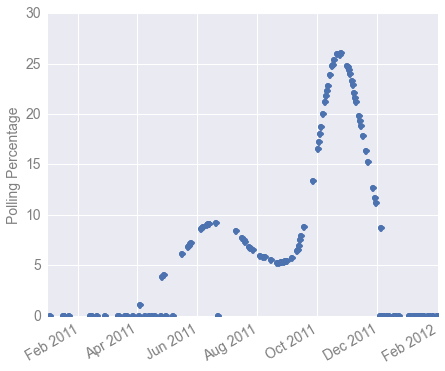

In [65]:
i=10
xmin=datetime.datetime(2011,1,1)
xmax=datetime.datetime(2012,2,1)
ymin=0;ymax=45;
%matplotlib inline
ilabel=topics[i][2].rsplit()[1]
top=topics[i][1]#topic to consider for now
print top
data[top]['date']=map(lambda x:date_parse(x),data[top]['vd'] )
fig, ax = plt.subplots(figsize=(7,6),)
#ax2=ax.twinx()
#ax2.get_yaxis().tick_right()
#ax2.set_ylim(0,30)
#df[1][['tl','vd','vc']]
#fig, ax = plt.subplots(figsize=(7,6),)
ax.set_title("Herman Cain 2011-2012", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14,colors='Gray')
ax.title.set_color('Gray')
plt.plot_date(data[top][['date']].values,data[top][['vc']].values/100)
#plt.plot_date(dfhuff[['date']].values,100*dfhuff[[ilabel]].values,'ok')
plt.ylabel("Page Views (thousands)", fontsize=14,color='Gray')
fig.autofmt_xdate()
plt.xlim([xmin,xmax])
sns.despine()
plt.show()

fig, ax = plt.subplots(figsize=(7,6),)

a=plt.plot_date(dfhuff[['date']].values,dfhuff[[ilabel]].values,label=ilabel)
plt.xlim([xmin,xmax])
plt.ylabel("Polling Percentage", fontsize=14,color='Gray')
ax.tick_params(axis='both', which='major', labelsize=14,colors='Gray')
#plt.ylim([ymin,ymax*1000])
fig.autofmt_xdate()
sns.despine()
plt.show()

newtgingrich


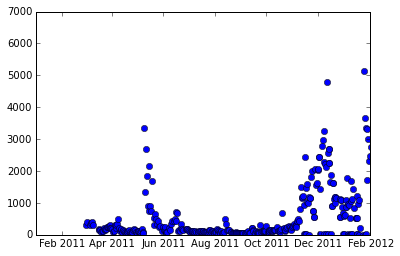

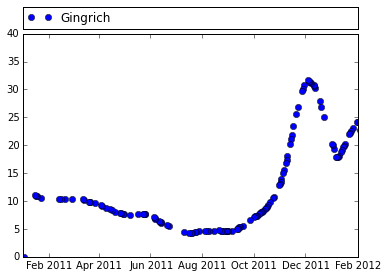

In [13]:
i=4
xmin=datetime.datetime(2011,1,1)
xmax=datetime.datetime(2012,2,1)
ymin=0;ymax=40;
%matplotlib inline
ilabel=topics[i][2].rsplit()[1]
top=topics[i][1]#topic to consider for now
print top
data[top]['date']=map(lambda x:date_parse(x),data[top]['vd'] )
#df[1][['tl','vd','vc']]
plt.plot_date(data[top][['date']].values,data[top][['vc']].values)
plt.xlim([xmin,xmax])
plt.ylim([0,7000])
plt.show()

a=plt.plot_date(dfhuff[['date']].values,dfhuff[[ilabel]].values,label=ilabel)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=3, mode="expand", borderaxespad=0.)

plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.show()

ricksantorum


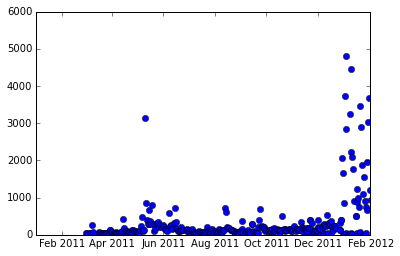

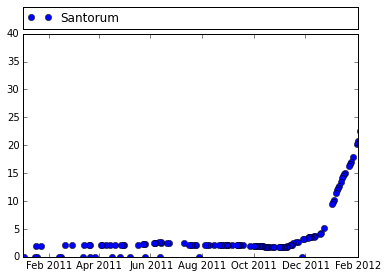

In [14]:
i=5
xmin=datetime.datetime(2011,1,1)
xmax=datetime.datetime(2012,2,1)
ymin=0;ymax=40;
%matplotlib inline
ilabel=topics[i][2].rsplit()[1]
top=topics[i][1]#topic to consider for now
print top
data[top]['date']=map(lambda x:date_parse(x),data[top]['vd'] )
#df[1][['tl','vd','vc']]
plt.plot_date(data[top][['date']].values,data[top][['vc']].values)
plt.xlim([xmin,xmax])
plt.ylim([0,6000])
plt.show()

a=plt.plot_date(dfhuff[['date']].values,dfhuff[[ilabel]].values,label=ilabel)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=3, mode="expand", borderaxespad=0.)

plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
a=plt.show()